In [1]:
import math
import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import sympy; sympy.init_printing()
import yfinance as yf
from datetime import datetime

from dateutil.relativedelta import relativedelta

In [2]:
S0=84.20    # spot stock price
K=85.0     # strike
T=.08333333 # maturity 
r=0.00043       # risk free rate 
sig=0.3344     # diffusion coefficient or volatility

In [3]:
N = 25000              # number of periods or number of time steps  
payoff = "call"        # payoff 

dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

V = np.zeros(N+1)                             # initialize the price vector
S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability   

if payoff =="call":
    V[:] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:] = np.maximum(K-S_T, 0.0)

for i in range(N-1, -1, -1):
    V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
    S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
    if payoff=="call":
        V = np.maximum( V, S_T-K )
    elif payoff=="put":
        V = np.maximum( V, K-S_T )
    
print("American BS Tree Price: ", V[0])

American BS Tree Price:  2.8737370849199064


In [15]:
def abtp(stock):
    # Get end date as November 15, 2021
    edate = datetime(2021, 11, 16)

    #Start date as 6 months ago from today
    sdate = edate + relativedelta(months=-6)

    #Change dates to strings
    sdate = datetime.strftime(sdate,"%Y-%m-%d")
    edate = datetime.strftime(edate,"%Y-%m-%d")

    #get historical data of stock
    df = yf.download(stock, start = sdate, end = edate)
    
    #Calculate Log Return for volatility
    log_returns = np.log(df['Close']/df['Close'].shift(1))
    
    #Calculate volatility
    sigma = log_returns.std() * math.sqrt(252)#len(df['Close'])

    #Find Risk-Free Rate 12 week t bill 
    r = yf.download('^IRX', start = edate, end = edate)
    r = r['Close'][0]/100

    #Find days until option maturity date
    tick = yf.Ticker(stock)
    print(tick.options[3])
    #t = datetime.strptime(tick.options[3],"%Y-%m-%d") - datetime.strptime(edate,"%Y-%m-%d")
    t = 27/252

    #strikes
    k = [295, 300, 305, 310, 315, 320, 325, 330, 335, 340]

    #stock price
    s = df['Close'][-1]

    print(s,k,sigma,r,t)
    
    prices = []
    
    for x in range(0,len(k)):
        N = 25000              # number of periods or number of time steps  
        payoff = "put"        # payoff 

        dT = float(t) / N                             # Delta t
        u = np.exp(sigma * np.sqrt(dT))                 # up factor
        d = 1.0 / u                                   # down factor 

        V = np.zeros(N+1)                             # initialize the price vector
        S_T = np.array( [(s * u**j * d**(N - j)) for j in range(N + 1)] )  # price S_T at time T

        a = np.exp(r * dT)    # risk free compound return
        p = (a - d)/ (u - d)  # risk neutral up probability
        q = 1.0 - p           # risk neutral down probability   

        if payoff =="call":
            V[:] = np.maximum(S_T-k[x], 0.0)
        elif payoff =="put":
            V[:] = np.maximum(k[x]-S_T, 0.0)

        for i in range(N-1, -1, -1):
            V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
            S_T = S_T * u                    # it is a tricky way to obtain the price at the previous time step
            if payoff=="call":
                V = np.maximum( V, S_T-k[x] )
            elif payoff=="put":
                V = np.maximum( V, k[x]-S_T )

        prices.append(V[0])
        
    #Create dataframe of strikes and prices
    z = {'Strike':k, 'Put Price':prices}
    prices = pd.DataFrame(data=z)
    return(prices)
    print(prices)

In [16]:
abtp('CRM')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2021-12-23
305.489990234375 [295, 300, 305, 310, 315, 320, 325, 330, 335, 340] 0.22428467183119555 0.00039999999105930326 0.10714285714285714


,Strike,Put Price
0,295,4.519539
1,300,6.383793
2,305,8.689021
3,310,11.437842
4,315,14.611326
5,320,18.173042
6,325,22.073988
7,330,26.258758
8,335,30.671984
9,340,35.261784


In [20]:
bid = [7.50, 9.65, 11.80, 14.60, 17.45, 20.75, 24.30, 28.20, 32.30, 36.65]
ask = [8.55, 10.20, 12.70, 15.55, 18.75, 21.90, 25.60, 29.40, 33.55, 38.15]
mid = []
for x in range(0, len(bid)):
    mid.append(round((ask[x] + bid[x])/2,3))
k = [295, 300, 305, 310, 315, 320, 325, 330, 335, 340]
tree_price = [4.519539, 6.383793, 8.689021, 11.437842, 14.611326, 18.173042, 22.073988, 26.258758, 30.671984, 35.261784]

d = {'Strike': k, 'Bloomberg Mid': mid, 'Binomial Price': tree_price}
df = pd.DataFrame(data = d)
print(df)

   Strike  Bloomberg Mid  Binomial Price
0     295          8.025        4.519539
1     300          9.925        6.383793
2     305         12.250        8.689021
3     310         15.075       11.437842
4     315         18.100       14.611326
5     320         21.325       18.173042
6     325         24.950       22.073988
7     330         28.800       26.258758
8     335         32.925       30.671984
9     340         37.400       35.261784


Text(0.5, 1.0, 'Put Prices')

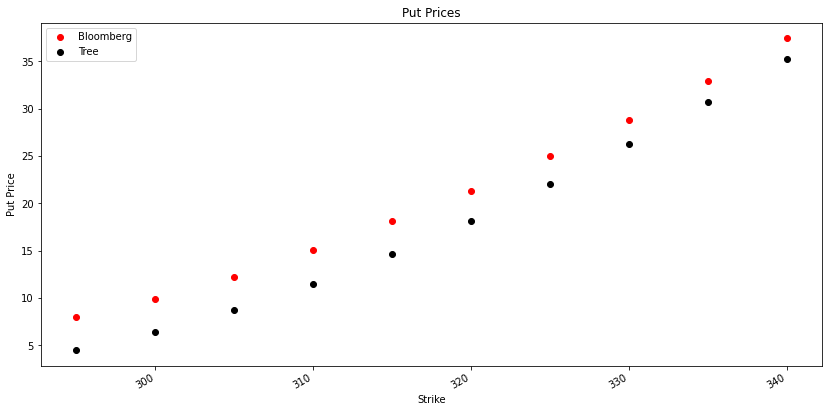

In [25]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.set_xlabel('Strike')
ax.set_ylabel('Put Price')
ax.scatter(k, mid, color = 'red', label = 'Bloomberg')
ax.scatter(k, tree_price, color = 'black', label = 'Tree')
fig.autofmt_xdate()
ax.legend()
plt.title('Put Prices')

In [26]:
diff = []
for x in range(0, len(bid)):
    diff.append(round((mid[x] - tree_price[x]),3))
print(diff)

[3.505, 3.541, 3.561, 3.637, 3.489, 3.152, 2.876, 2.541, 2.253, 2.138]


In [27]:
bid = [17.5, 14.80, 11.90, 9.80, 7.65, 6.05, 4.70, 3.75, 2.81, 2.26]
ask = [18.95, 15.60, 12.95, 10.65, 8.65, 6.85, 5.55, 4.30, 3.55, 2.76]
mid = []
for x in range(0, len(bid)):
    mid.append(round((ask[x] + bid[x])/2,3))
k = [295, 300, 305, 310, 315, 320, 325, 330, 335, 340]
tree_price = [15.02, 11.87, 9.19, 6.94, 5.11, 3.68, 2.58, 1.76, 1.17, 0.76]
bs = [15.02, 11.89, 9.19, 6.94, 5.11, 3.68, 2.58, 1.76, 1.17, 0.76]

Text(0.5, 1.0, 'Call Prices')

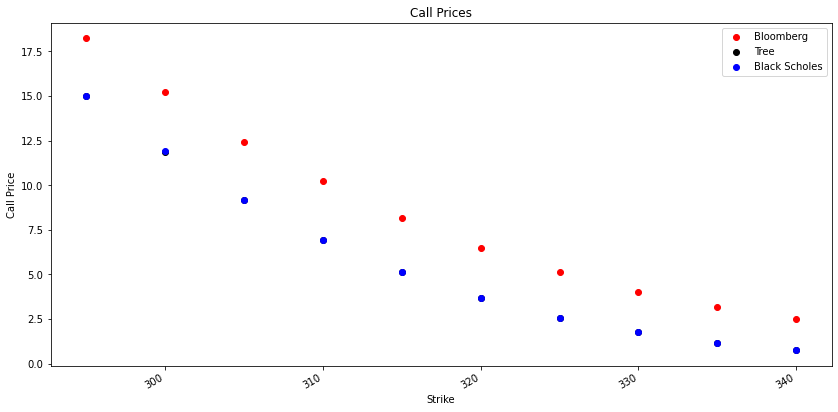

In [28]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.set_xlabel('Strike')
ax.set_ylabel('Call Price')
ax.scatter(k, mid, color = 'red', label = 'Bloomberg')
ax.scatter(k, tree_price, color = 'black', label = 'Tree')
ax.scatter(k, bs, color = 'blue', label = 'Black Scholes')
fig.autofmt_xdate()
ax.legend()
plt.title('Call Prices')

In [30]:
edate = datetime(2021, 11, 16)

#Start date as 6 months ago from today
sdate = edate + relativedelta(months=-3)

#Change dates to strings
sdate = datetime.strftime(sdate,"%Y-%m-%d")
edate = datetime.strftime(edate,"%Y-%m-%d")

#get historical data of stock
df = yf.download('CRM', start = sdate, end = edate)
    
#Calculate Log Return for volatility
log_returns = np.log(df['Close']/df['Close'].shift(1))
    
#Calculate volatility
sigma = log_returns.std() * math.sqrt(252)#len(df['Close'])

print(sigma)

[*********************100%***********************]  1 of 1 completed
0.23069327641619247
